# Text Data
## Data Science Tools I
### Terron Ishihara | University of Denver


---

Main reference: [*Introduction to Machine Learning with Python: A Guide for Data Scientists* by Andres C. Müller and Sarah Guido](https://www.amazon.com/Introduction-Machine-Learning-Python-Scientists-ebook/dp/B01M0LNE8C)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Types of Data Represented as Strings

In a previous lecture, we observed that in order for features to be interpreted by machine learning models, they must be continuous (numerical and interpretable as numbers). Some features are categorical, often represented with strings. In a classification task, the target vector is typically a categorical feature with the unique values of that feature being the possible class labels.

Just as not all numerical data is continuous, not all string data is categorical. Generally there are four types of string data:
* Categorical data
* Free strings that can be symantically mapped to categories
* Structured string data
* Text data

Categorical is what we've discussed already, where there is a finite set of string options that can be chosen from for a particular observation. For example, a survey of people's favorite colors could have the options "red", "green", "blue", "yellow", "orange", "purple", etc.

Particularly in scenarios like surveys where, instead of a drop-down menu or something, users are able to type freely, typos can occur. Someone could respond saying their favorite color is "yelow" for example, which we could map to the category "yellow". Some responses could say "gray" while others say "grey". (An easy way to generally remember which to use is that "gr**A**y" is more often used by **A**merican speakers while "gr**E**y" is more often used by British **E**nglish speakers.) Some responses could be more specific, saying something like "navy blue" which could be mapped to "blue". Ultimately "free strings" like these are actually categorical but require manual assignment to the categories of interest.

Structured string data includes things like address, phone numbers, place names, people names, and other identifiers.

## Text Data

Text data is freeform, consisting of phrases or sentences. Text data could generally be considered anything that communicates a thought that isn't one of the previous categories, perhaps an email, a social media post, a speech, a line of dialogue, etc. Some key terms to note here:
* An "atomic" entity of text can be called a **word**, **term**, or **token** depending on the context.
* A body of text (e.g. one email) is called a **document**.
* A collection of documents is called a **corpus** (plural: **corpora**).
* The field of research related to search through corpora is called **information retrieval (IR)**.
* The field of research related to analyzing text data is called **natural language processing (NLP)**.





# Example Application: Sentiment Analysis on Movie Reviews

A classic example of natural language processing is sentiment analysis, where the objective is to classify the **polarity** of a document. Sentiment analysis in its simplest form is a binary classification of either "positive" or "negative", though certainly more fine-grained classifications exist. In fact, IMDB's rating system is based on values between 1 and 10, but the dataset we will use consolidates these values into "positive" if 6 or higher and "negative" otherwise.

Data Source: http://ai.stanford.edu/~amaas/data/sentiment/ 

In [2]:
!wget "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
!tar -xf aclImdb_v1.tar.gz

tar: Error opening archive: Failed to open 'aclImdb_v1.tar.gz'


The data is pre-split into train and test, each as folders within which are folders label `neg` and `pos` for the negative and positive reviews respectfully. The `train` folder has a folder for unsupervised learning (without labels), but we will stick with the supervised version of this classification.

`sklearn`'s `load_files` method conveniently can load files provided in this format.

In [7]:
from sklearn.datasets import load_files

# Ignore the `unsup` folder
reviews_train = load_files("/content/aclImdb/train/", categories=['neg','pos'])
X_train, y_train = reviews_train.data, reviews_train.target

# Take only part of the data to train and test because the corpus is so large
sample_size = 8000
X_train = X_train[:sample_size]
y_train = y_train[:sample_size]

print(f"Type of X_train: {type(X_train)}")
print(f"Length of X_train: {len(X_train)}") 
print(f"X_train[1]:\n{X_train[1]}")

AttributeError: 'list' object has no attribute 'data'

The string for the movie review is given as a byte literal, which is a special string that encodes using ASCII, characters represented by ASCII values 0 to 255. Any characters that are not within this range are given as escaped characters (e.g. `\x41` is `'A'`).

Aside from some escaped characters, the review text contains HTML newline tags, `<br />`. These shouldn't affect the model much, but we might as well get rid of them since they do not contain any semantic significance. Note that we do not replace these with empty strings since we still want whitespace separating each word in the review.

In [5]:
# Remove html <br /> tags
X_train = [doc.replace(b"<br />", b" ") for doc in X_train]

NameError: name 'X_train' is not defined

We can observe how many positive versus negative labels there are using `np.bincount`.

In [8]:
print(f"Samples per class (training): {np.bincount(y_train)}")
print(f"Labels: {np.unique(y_train)}")

NameError: name 'y_train' is not defined

We can prepare the test data in the same manner.

In [9]:
from sklearn.datasets import load_files

# 'unsup' does not exist in the test folder, so we don't have to ignore it
reviews_test = load_files("/content/aclImdb/test/")
X_test, y_test = reviews_test.data, reviews_test.target

X_test = X_test[:sample_size]
y_test = y_test[:sample_size]

# Remove HTML <br />
X_test = [doc.replace(b"<br />", b" ") for doc in X_test]

print(f"Type of X_test: {type(X_test)}")
print(f"Length of X_test: {len(X_test)}") 

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/content/aclImdb/test/'

# Representing Text as a Bag of Words

Anyone familiar with the board game Scrabble or Bananagrams should have an intuitive image in their mind of a bag of letters; both of these games involve placing tiles, each with one letter written on them, in a grid-like fashion to create words. Which letters you get is totally random since all tiles are thrown into the bag and the bag is shaken up.

The **bag-of-words** approach to representing text follows the same idea but at a word level rather than letters. Regardless of the ordering of the words in our corpus, we consider them all to be separate entities independent of one another. In doing so, we disregard sentence structure, grammar, and other linguistic rules. Certainly this sort of information is extremely useful and is taken into consideration in other models. Surprisingly, however, we can get pretty good performance with a bag-of-words approach.

Converting a corpus into a bag of words involves three steps:

* *Tokenization*: Split each document into words (tokens) by splitting on, say, whitespace and punctuation.
* *Vocabulary building*: Create a vocabulary of words that appear in the corpus and number them (say, in alphabetical order)
* *Encoding*: For each document, count how many times each word in the vocabulary appears in that document.





## Simple Dataset

Each of the steps listed above have finer details about them, but for now let's use `sklearn`'s tools to perform these steps on a simple dataset.

In [11]:
bilbo_speech = ["I don't know half of you half as well as I should like",
                "and I like less than half of you half as well as you deserve."]

The `CountVectorizer` performs the aforementioned steps using an efficient representation.

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()
vect.fit(bilbo_speech)

CountVectorizer()

The `token_pattern` parameter designates a **regular expression** used to separate the corpus into tokens. Regular expressions are powerful tools for representing patterns in text, the details of which are too abundant to go over in this lecture. Suffice to say, `(?u)\\b\\w\\w+\\b` matches entities that are separated by word boundaries and that contain at least two letters or numbers.

Printing the vocabulary illustratest that the words are encoded with integer labels corresponding to their position in sorted order.

In [13]:
print(f"Vocabulary size: {len(vect.vocabulary_)}")
print(f"Vocabulary content:\n {vect.vocabulary_}")

Vocabulary size: 13
Vocabulary content:
 {'don': 3, 'know': 5, 'half': 4, 'of': 8, 'you': 12, 'as': 1, 'well': 11, 'should': 9, 'like': 7, 'and': 0, 'less': 6, 'than': 10, 'deserve': 2}


Printing the transformed text's representation, we see that the result is a sparse matrix, which is a memory-efficient means of representing matrices that contain lots of zeroes where only non-zero values are stored.

In [14]:
bag_of_words = vect.transform(bilbo_speech)
print(f"bag_of_words: {repr(bag_of_words)}")

bag_of_words: <2x13 sparse matrix of type '<class 'numpy.int64'>'
	with 19 stored elements in Compressed Sparse Row format>


Printing the dense version of this matrix will show what the full representation looks like.

In [15]:
print(f"Dense representation of bag_of_words:\n{bag_of_words.toarray()}")

Dense representation of bag_of_words:
[[0 2 0 1 2 1 0 1 1 1 0 1 1]
 [1 2 1 0 2 0 1 1 1 0 1 1 2]]


These counts are per-document and correspond to the words as ordered in the vocabulary encoding. Take the first string as an example. The first word in the vocabulary encoding is "and", which does not appear in the first string, so the value 0 is at the first index. The next word in the vocabulary is "as", which shows up twice in the first string, yielding the number 2, and so on for the remaining words in the vocabulary.



## Movie Reviews as Bag-Of-Words

Let's apply the same technique to the movie reviews dataset.

In [16]:
vect = CountVectorizer().fit(X_train)
X_train_bow = vect.transform(X_train)
print("X_train_bow:\n{}".format(repr(X_train_bow)))

NameError: name 'X_train' is not defined

The `get_feature_names` method in `CountVectorizer` can give us more insight on what the `CountVectorizer` is actually storing.

In [17]:
feature_names = vect.get_feature_names()
print(f"Number of features: {len(feature_names)}")
print(f"First 20 features:\n{feature_names[:20]}")
print(f"Features 20010 to 20030:\n{feature_names[20010:20030]}")
print(f"Every 2000th feature:\n{feature_names[::2000]}")

Number of features: 13
First 20 features:
['and', 'as', 'deserve', 'don', 'half', 'know', 'less', 'like', 'of', 'should', 'than', 'well', 'you']
Features 20010 to 20030:
[]
Every 2000th feature:
['and']


C:\Users\dunca\anaconda3\envs\GIS\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Interestingly, the first few "words" in the vocabulary are actually numbers. It is not likely that many of these have any significant meaning (though `007` does mean something with regard to James Bond films). 

Also notice that the word "homeowner" and its plural "homeowners" are both in the vocabulary. Given that we are considering all words to be independent entities in this bag-of-words approach, it may make more sense to consider both "homeowner" and "homeowners" as the same word since the pluralization does not add any extra useful information.

Let's run a linear classifier to see what sort of result we get.



In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

scores = cross_val_score(LogisticRegression(max_iter=1000), X_train_bow, y_train, cv=5) 
print(f"Mean cross-validation accuracy: {scores.mean():.2f}")

NameError: name 'X_train_bow' is not defined

Logistic regression does have a hyperparameter called C that can be tuned to possibly achieve a better score. Since we're focusing on text processing, however, let's consider removing some tokens from our corpus in hopes that tokens that are not useful in discerning between labels will be removed.

One way of doing this is by setting a minimum number of documents a token must appear in, referred to as its **document frequency**. For example, we might find that a couple movie reviews (perhaps for "Bill and Ted's Excellent Adventure" and its sequel) uses the word "triumphant" a lot, while all the others do not. This means that "triumphant" has significance for a couple documents but is not relevant to any others. Applying this globally should hopefully remove less informative tokens.

In [ ]:
vect = CountVectorizer(min_df=5).fit(X_train) # Specify minimum document frequency
X_train_bow = vect.transform(X_train)
print(f"X_train with min_df: {repr(X_train_bow)}")

Compare the number of features here versus the number of features in the original bag-of-words X_train. With so many tokens removed, let's see if the model has improved.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

scores = cross_val_score(LogisticRegression(max_iter=1000), X_train_bow, y_train, cv=5) 
print(f"Mean cross-validation accuracy: {scores.mean():.2f}")

It looks like there is still work to be done, but at least the dimensionality of our feature matrix has been reduced.

# Stop Words

Another means of reducing the number of features (i.e. removing unnecessary tokens) is the use of **stop words**. There are plenty of words whose minimum document frequency is high (some probably appear in almost every document) but also do not provide any more semantic or useful information, such as "the", "an", "but", etc. These are called stop words and libraries designed for NLP tasks typically have a list of stop words for the most common languages.



In [19]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

print(f"Number of stop words: {len(ENGLISH_STOP_WORDS)}")
print(f"Every 10th stopword:\n{list(ENGLISH_STOP_WORDS)[::10]}")

Number of stop words: 318
Every 10th stopword:
['amoungst', 'name', 'our', 'seemed', 'call', 'rather', 'may', 'across', 'amongst', 'have', 'sometimes', 'take', 'too', 'front', 'him', 'twenty', 'again', 'mill', 'afterwards', 'fifteen', 'what', 'here', 'together', 'serious', 'eleven', 'nor', 'someone', 'namely', 'it', 'some', 'themselves', 'whatever']


Let's see if our score improves with stop words removed.

In [25]:
vect = CountVectorizer(min_df=5, stop_words='english').fit(X_train)
X_train_bow = vect.transform(X_train)
print(f"X_train with min_df and stop words: {repr(X_train_bow)}")

ValueError: max_df corresponds to < documents than min_df

In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

scores = cross_val_score(LogisticRegression(max_iter=1000), X_train_bow, y_train, cv=5) 
print(f"Mean cross-validation accuracy: {scores.mean():.2f}")

NameError: name 'X_train_bow' is not defined

Removing stop words is more effective with smaller datasets since there may not be enough distinct words for the model to discern between stop words and informative words. Since this dataset is rather large, we find that removing stop words actually decreases the accuracy slightly, so it may not be worth utilizing in the long run.

# Rescaling the Data with tf-idf

Instead of dropping features that are deemed unimportant, another approach is to rescale features by how informative we expect them to be. One of the most common ways to do this is using the **term frequency–inverse document frequency (tf–idf)** method. Recalling the "triumphant" example from before, although that word is perhaps not as significant across all documents, the fact that it appears many times in one document is also important. Overall, we want to give higher weight to terms that appear often within a document, but not in very many documents. In other words, we want term frequency (number of times a term appear in a given document) to be higher and document frequency (number of documents a term appears in at least once) to be lower.

$$
\text{tfidf} = \text{tf}(w,d) \cdot \log(\frac{N+1}{N_w+1}) + 1
$$
where
* $\text{tf}(w,d)$ is the term frequency (the number of times word $w$ appears in the query document $d$)
* $N$ is the number of documents in the training set
* $N_w$ is the document frequency of $w$ (the number of documents $w$ appears in)

`sklearn`'s `TfidfTransformer` will take the bag-of-words representation given by `CountVectorizer` and calculate the tfidf of each term and use that value instead of a raw word count. `TfidfVectorizer` is a combination of both of these classes.

The tfidf is also normalized so any given document's vector of tfidf scores has a Euclidean norm of 1. In doing so, a document's length (the number of words in a document) is not factored into the calculation. This is significant particularly in information retrieval where tfidf is used to determine what document is most relevant to your query (e.g. Google search). Someone could artificially attach many words or repeat certain words to make the search engine more likely to pick their website, which is prevented by this normalization.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

vect = TfidfVectorizer(min_df=5)
X_train_tfidf = vect.fit_transform(X_train)

scores = cross_val_score(LogisticRegression(max_iter=1000), X_train_tfidf, y_train, cv=5) 
print(f"Mean cross-validation accuracy: {scores.mean():.2f}")

Mean cross-validation accuracy: 0.87


In [ ]:
# Compute max value for each feature
max_value = X_train_tfidf.max(axis=0).toarray().ravel()
# Sort the values based on tfidf
sorted_by_tfidf = max_value.argsort()
# Get feature names
feature_names = np.array(vect.get_feature_names())
# Get the first 20 tfidf scores and use them to index into feature array
print(f"Features with lowest tfidf:\n{feature_names[sorted_by_tfidf[:20]]}")
# Do the same, but for the last 20
print(f"Features with highest tfidf: \n{feature_names[sorted_by_tfidf[-20:]]}")

Features with lowest tfidf:
['panning' 'gleefully' 'dominance' 'naïve' 'dissolution' 'conquered'
 'tumbling' 'betraying' 'emerald' 'growling' 'landmarks' 'evaluate'
 'sedate' 'sympathetically' 'flourished' 'eliminating' 'doorstep' 'relish'
 'informs' 'claustrophobia']
Features with highest tfidf: 
['modesty' 'pia' 'naschy' 'pierce' 'che' 'worms' 'gundam' 'reese' 'zombi'
 'darius' 'elvira' 'bruce' 'ants' 'brendan' 'seagal' 'bye' 'botched'
 'demons' 'woo' 'pokemon']


Terms with low tfidf either are very commonly used across documents or are only used sparingly. The high tfidf terms should appear in fewer documents but many times within those documents. It's not surprising that terms like `pokemon` and `elvira` and `gundam` have high tfidf since these identify the movies/actors the reviews are talking about.

Terms with low idf alone are ones that appear in many documents. These could be used to create a dynamic list of stop words. Some terms are specific to the corpus, which could end up lacking meaning with how often they are used (e.g. "movie").

In [ ]:
sorted_by_idf = np.argsort(vect.idf_)
print(f"Features with lowest idf:\n{feature_names[sorted_by_idf[:100]]}")

Features with lowest idf:
['the' 'and' 'of' 'to' 'this' 'is' 'it' 'in' 'that' 'but' 'for' 'with'
 'was' 'as' 'on' 'movie' 'not' 'be' 'one' 'have' 'film' 'are' 'you' 'all'
 'at' 'an' 'by' 'like' 'from' 'so' 'who' 'his' 'there' 'out' 'they' 'he'
 'if' 'just' 'about' 'or' 'has' 'can' 'what' 'good' 'some' 'when' 'more'
 'time' 'up' 'even' 'very' 'only' 'would' 'no' 'my' 'see' 'really' 'which'
 'well' 'story' 'had' 'me' 'than' 'much' 'their' 'do' 'other' 'were' 'get'
 'been' 'don' 'her' 'also' 'most' 'first' 'great' 'into' 'made' 'how'
 'people' 'because' 'will' 'we' 'make' 'way' 'after' 'could' 'bad' 'any'
 'she' 'then' 'too' 'them' 'think' 'watch' 'movies' 'seen' 'acting'
 'being' 'its']


Stepping back to the overall objective here, we ultimately want to classify reviews as being positive or negative. These labels have nothing to do with term frequency, document frequency, stopwords, etc. Tfidf and the related features can help us transform the data to make the model fit better, but we haven't yet seen what our model has learned.

The textbook author's `mglearn` library has a nice visualization plot that can show us what the most significant coefficients are in our resulting model. Those that most correlate with positive labels are given higher positive coefficients, and the opposite for negative labels.

In [ ]:
!pip install mglearn

     |████████████████████████████████| 542kB 7.3MB/s 
  Created wheel for mglearn: filename=mglearn-0.1.9-py2.py3-none-any.whl size=582638 sha256=2e244d0750085c089442d68e62a2cfd4e38db620daf329a10b5959dabf3d26f9
  Stored in directory: /root/.cache/pip/wheels/eb/a6/ea/a6a3716233fa62fc561259b5cb1e28f79e9ff3592c0adac5f0
Successfully built mglearn


In [22]:
import mglearn

logreg = LogisticRegression(max_iter=1000).fit(X_train_tfidf, y_train)
mglearn.tools.visualize_coefficients(logreg.coef_, feature_names, n_top_features=40)

ModuleNotFoundError: No module named 'mglearn'

# Bag of Words with n-grams

The previous plot demonstrates that the words "excellent" and "great" become associated with positive reviews while "bad" and "worst" are associated with negative ones, as to be expected. But what if we come across a review that says something like "The movie is not great" or "It's wasn't bad."? By viewing each word as independent of all others, we lose connotations that can change with a word like "not" (though this is admittedly an extreme version of this predicament). 

What if, instead, we use *pairs* of words instead of single words (also called **unigrams**)? These pairs are referred to as **bigrams**. Similarly, three-word groups are called **trigrams**, and generally these are called **n-grams**. The overall approach remains the same, but the level of granularity for our vocabulary changes.

Let's observe a simple example of this with the sample text from earlier.

In [ ]:
count_vect = CountVectorizer(ngram_range=(1,1))
count_vect.fit(bilbo_speech)

print(f"Vocabulary size: {len(count_vect.vocabulary_)}")
print(f"Vocabulary:\n{count_vect.vocabulary_}")

Vocabulary size: 13
Vocabulary:
{'don': 3, 'know': 5, 'half': 4, 'of': 8, 'you': 12, 'as': 1, 'well': 11, 'should': 9, 'like': 7, 'and': 0, 'less': 6, 'than': 10, 'deserve': 2}


Here we get the same results as before, but explicitly stating that we want n-grams from n=1 to n=1, so excluding all other values of n. Let's see what happens when we only ask for bigrams.

In [ ]:
count_vect = CountVectorizer(ngram_range=(2,2))
count_vect.fit(bilbo_speech)

print(f"Vocabulary size: {len(count_vect.vocabulary_)}")
print(f"Vocabulary:\n{count_vect.vocabulary_}")

Vocabulary size: 16
Vocabulary:
{'don know': 4, 'know half': 7, 'half of': 6, 'of you': 10, 'you half': 15, 'half as': 5, 'as well': 2, 'well as': 13, 'as should': 1, 'should like': 11, 'and like': 0, 'like less': 9, 'less than': 8, 'than half': 12, 'as you': 3, 'you deserve': 14}


Naturally, we can specify a range of values for n.

In [ ]:
count_vect = CountVectorizer(ngram_range=(1,3))
count_vect.fit(bilbo_speech)

print(f"Vocabulary size: {len(count_vect.vocabulary_)}")
print(f"Vocabulary:\n{count_vect.vocabulary_}")

Vocabulary size: 44
Vocabulary:
{'don': 11, 'know': 19, 'half': 14, 'of': 28, 'you': 40, 'as': 3, 'well': 36, 'should': 31, 'like': 25, 'don know': 12, 'know half': 20, 'half of': 17, 'of you': 29, 'you half': 42, 'half as': 15, 'as well': 6, 'well as': 37, 'as should': 4, 'should like': 32, 'don know half': 13, 'know half of': 21, 'half of you': 18, 'of you half': 30, 'you half as': 43, 'half as well': 16, 'as well as': 7, 'well as should': 38, 'as should like': 5, 'and': 0, 'less': 22, 'than': 33, 'deserve': 10, 'and like': 1, 'like less': 26, 'less than': 23, 'than half': 34, 'as you': 8, 'you deserve': 41, 'and like less': 2, 'like less than': 27, 'less than half': 24, 'than half of': 35, 'well as you': 39, 'as you deserve': 9}


Let's try applying this approach to the movie review dataset.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

vect = TfidfVectorizer(min_df=5, ngram_range=(1,3)) # Use unigrams, bigrams, and trigrams
X_train_tfidf = vect.fit_transform(X_train)

scores = cross_val_score(LogisticRegression(max_iter=1000), X_train_tfidf, y_train, cv=5) 
print(f"Mean cross-validation accuracy: {scores.mean():.2f}")

Mean cross-validation accuracy: 0.87


Again we can observe what the most significant features are.

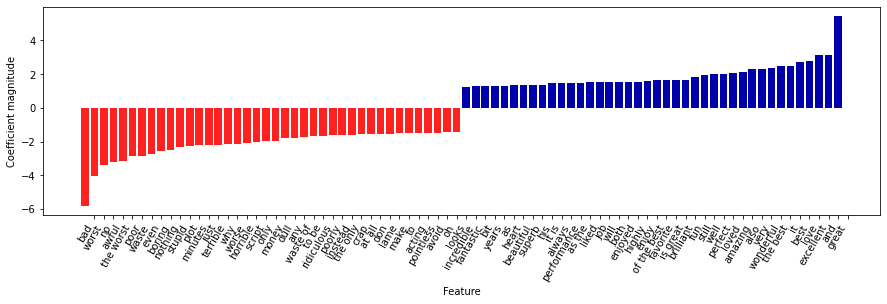

In [ ]:
logreg = LogisticRegression(max_iter=1000).fit(X_train_tfidf, y_train)
feature_names = np.array(vect.get_feature_names())
mglearn.tools.visualize_coefficients(logreg.coef_, feature_names, n_top_features=40)